## Spot price simulations

[Geometric Brownian Motion](https://en.wikipedia.org/wiki/Geometric_Brownian_motion) as is assumed in the Black-Scholes model.

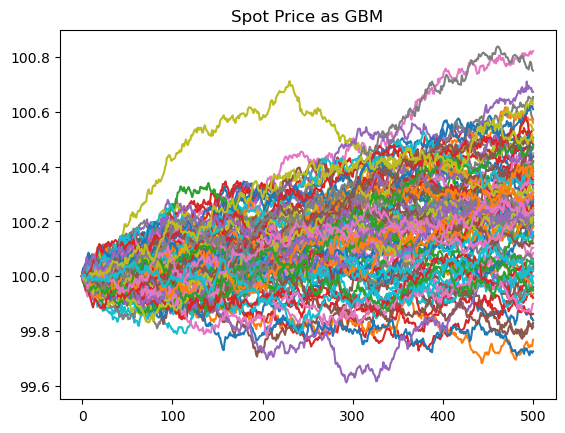

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from gbm import GeometricBrownianMotion

num_paths = 100
plt.plot(
    np.array(
        [
            GeometricBrownianMotion.simulate(
                init=100,
                mu=0.05,
                sigma=0.01,
                dt=0.0001,
                num_steps=500
            )
            for _ in range(num_paths)
        ]
    ).T
)
plt.title('Spot Price as GBM')
plt.show()

## Parameters and their influence on valuation

### European Options

In [2]:
import datetime
import options

call_options = {
    "ITM": options.EuropeanOption(
        option_type=options.OptionType.CALL,
        underlying=options.Stock("AAPL", 100),
        dividend_yield=None,
        qty=1,
        strike_price=95,
        expiration_date=datetime.date.today() + datetime.timedelta(days=90),
    ),
    "ATM": options.EuropeanOption(
        option_type=options.OptionType.CALL,
        underlying=options.Stock("AAPL", 100),
        dividend_yield=None,
        qty=1,
        strike_price=100,
        expiration_date=datetime.date.today() + datetime.timedelta(days=90),
    ),
    "OTM": options.EuropeanOption(
        option_type=options.OptionType.CALL,
        underlying=options.Stock("AAPL", 100),
        dividend_yield=None,
        qty=1,
        strike_price=105,
        expiration_date=datetime.date.today() + datetime.timedelta(days=90),
    ), 
} 

put_options = {
    "ITM": options.EuropeanOption(
        option_type=options.OptionType.PUT,
        underlying=options.Stock("AAPL", 100),
        dividend_yield=None,
        qty=1,
        strike_price=105,
        expiration_date=datetime.date.today() + datetime.timedelta(days=90),
    ),
    "ATM": options.EuropeanOption(
        option_type=options.OptionType.PUT,
        underlying=options.Stock("AAPL", 100),
        dividend_yield=None,
        qty=1,
        strike_price=100,
        expiration_date=datetime.date.today() + datetime.timedelta(days=90),
    ),
    "OTM": options.EuropeanOption(
        option_type=options.OptionType.PUT,
        underlying=options.Stock("AAPL", 100),
        dividend_yield=None,
        qty=1,
        strike_price=95,
        expiration_date=datetime.date.today() + datetime.timedelta(days=90),
    ),
}

#### Varying risk-free rate

In [3]:
def plot(ax, prices, xaxis, xlabel, ylabel, title):
    for (label, price) in prices:
        ax.plot(xaxis, price, label=label)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()

In [4]:
from models import black_scholes
from models import binomial
from models import lspi

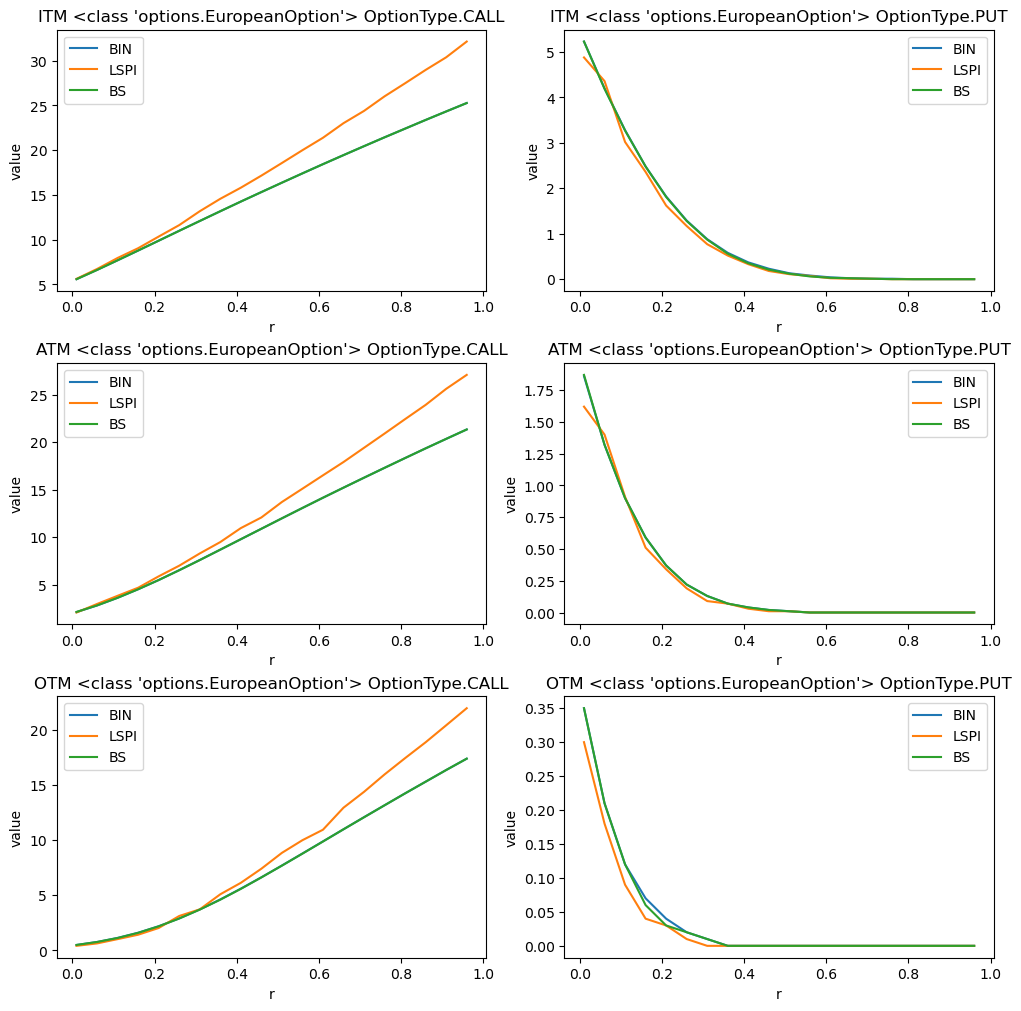

In [5]:
def vary_r(call_options, put_options, r_range=np.arange(0.01, 1, 0.05)):
    fig, axes = plt.subplots(
        ncols=2,
        nrows=3,
        figsize=(10, 10),
        constrained_layout=True
    )

    for call_or_put_options in [call_options, put_options]:
        for i, (moneyness, option) in enumerate(call_or_put_options.items()):
            ax = axes[i, 0 if option.is_call() else 1]
            bin_prices = [binomial.price_option(option, risk_free_rate=r, volatility=0.1, time_to_maturity_in_years=3/12) for r in r_range]
            lspi_prices = [lspi.price_option(option, risk_free_rate=r, volatility=0.1, time_to_maturity_in_years=3/12) for r in r_range]
            prices = [('BIN', bin_prices), ('LSPI', lspi_prices)]
            if isinstance(option, options.EuropeanOption):
                bs_prices = [black_scholes.price_option(option, risk_free_rate=r, volatility=0.1, time_to_maturity_in_years=3/12)[0] for r in r_range]
                prices.append(('BS', bs_prices))
            plot(ax, prices, r_range, 'r', 'value', f"{moneyness} {type(option)} {option.option_type}")

vary_r(call_options, put_options)

Notice that Binomial hugs the Black-Scholes line. This is expected as the calibrator we choose is CRR, which matches the first 2 moments of S_t: spot prices follow the same GBM. For put options, we don't seem much difference between the 3 models. However, for call options, LSPI seems to think they are worth more than what BS suggests. This is a potential trading opportunity in that, we know the expected payoff is more than the value of the option, so we buy the call option.

Also note that this is basically rho = partial derivative of V w.r.t risk-free rate. For BS model, it's given KD\*tau\*N(d2). We have D=exp(-rtau) which gives us the curve we see above. For put, it's minus tau*KD hence the opposite slope.

#### Varying implied volatility

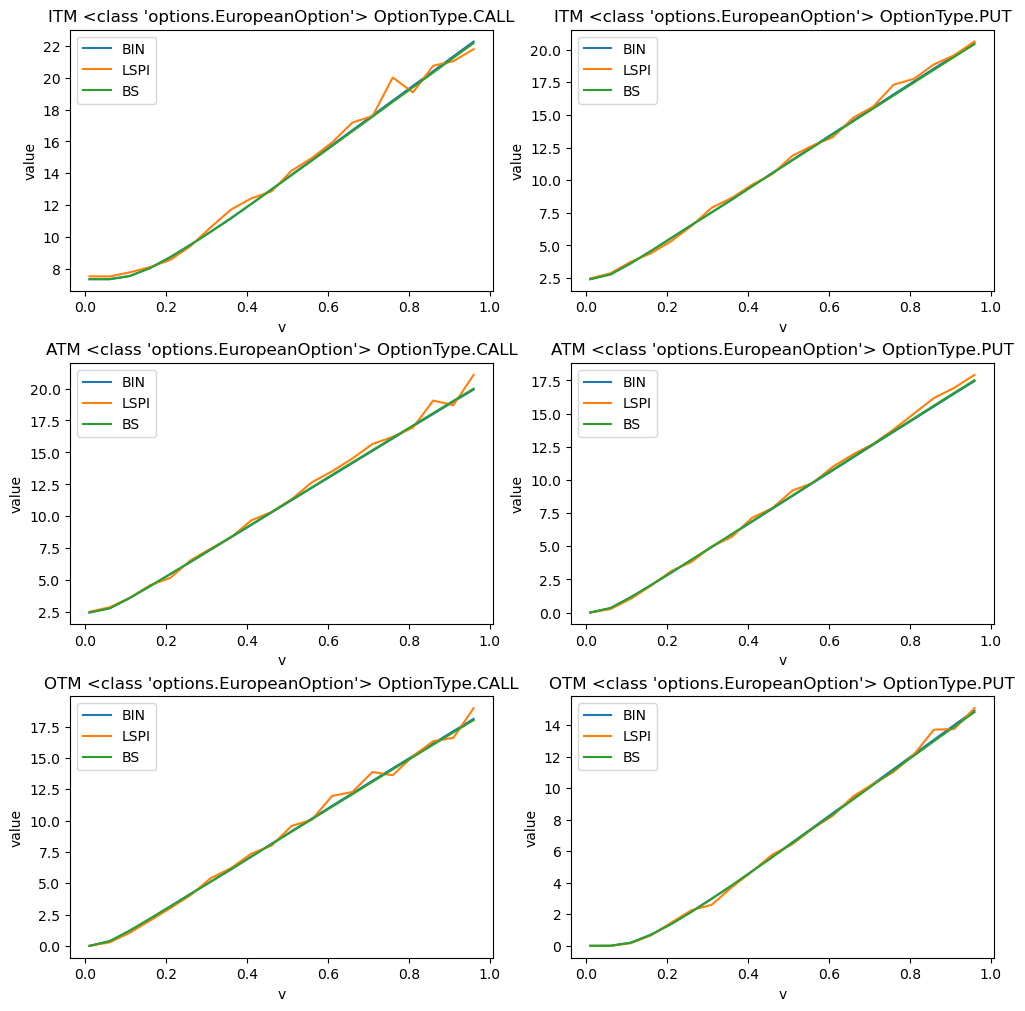

In [6]:
def vary_v(call_options, put_options, v_range=np.arange(0.01, 1, 0.05)):
    fig, axes = plt.subplots(
        ncols=2,
        nrows=3,
        figsize=(10, 10),
        constrained_layout=True
    )

    for call_or_put_options in [call_options, put_options]:
        for i, (moneyness, option) in enumerate(call_or_put_options.items()):
            ax = axes[i, 0 if option.is_call() else 1]
            bin_prices = [binomial.price_option(option, risk_free_rate=0.1, volatility=v, time_to_maturity_in_years=3/12) for v in v_range]
            lspi_prices = [lspi.price_option(option, risk_free_rate=0.1, volatility=v, time_to_maturity_in_years=3/12) for v in v_range]
            
            prices = [('BIN', bin_prices), ('LSPI', lspi_prices)]
            if isinstance(option, options.EuropeanOption):
                bs_prices = [black_scholes.price_option(option, risk_free_rate=0.1, volatility=v, time_to_maturity_in_years=3/12)[0] for v in v_range]
                prices.append(('BS', bs_prices))
            plot(ax, prices, v_range, 'v', 'value', f"{moneyness} {type(option)} {option.option_type}")

vary_v(call_options, put_options)

This curve would be vega. It's the same for both call and put options, unlike delta, theta and rho. Note the typical hockey stick graph. When volatility is close to 0, we can only expect a drift (due risk-free rate). So, the value would be future discounted price minus strike price. And as volatility increases, the payoff increases as well. There isn't much difference between the 3 models.

#### Varying time to maturity

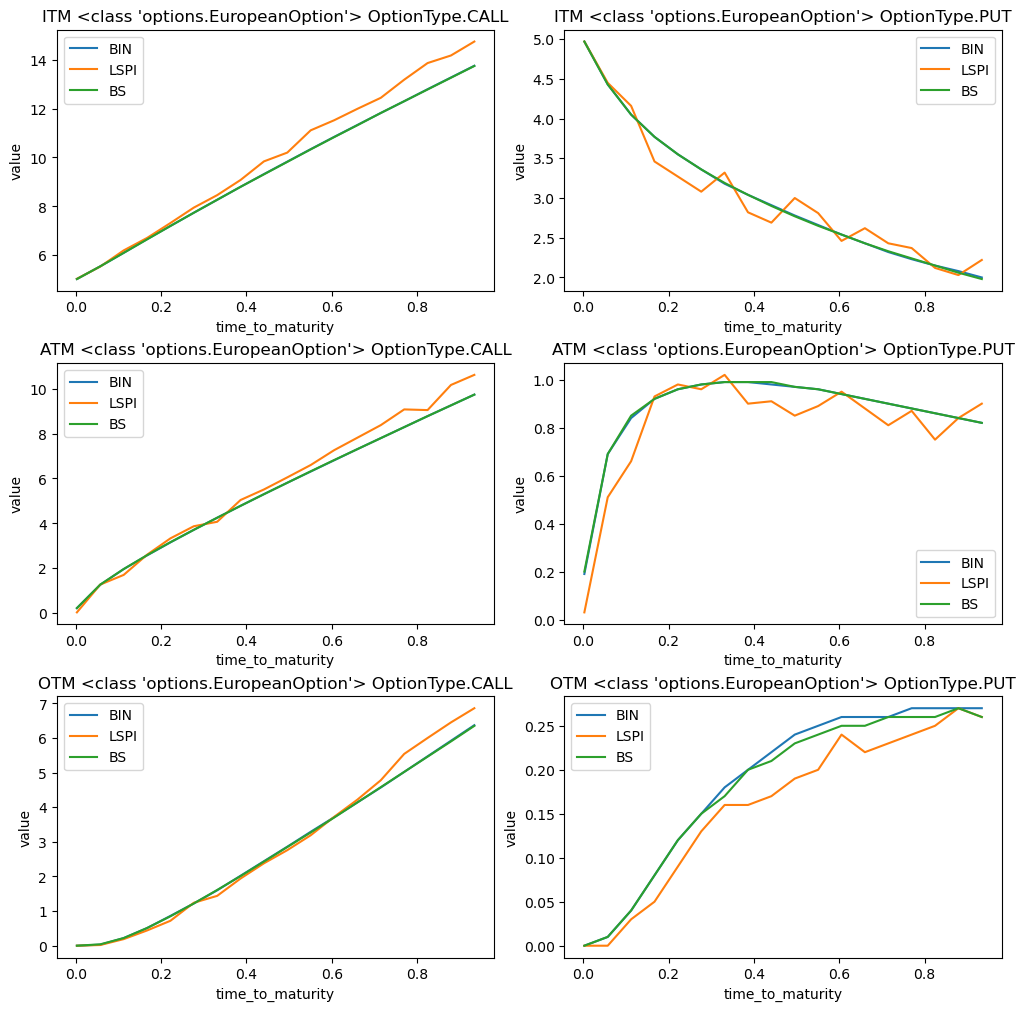

In [7]:
def vary_t(call_options, put_options, t_range=[(1 + 20*j)/365 for j in range(18)]):
    fig, axes = plt.subplots(
        ncols=2,
        nrows=3,
        figsize=(10, 10),
        constrained_layout=True
    )

    for call_or_put_options in [call_options, put_options]:
        for i, (moneyness, option) in enumerate(call_or_put_options.items()):
            ax = axes[i, 0 if option.is_call() else 1]
            bin_prices = [binomial.price_option(option, risk_free_rate=0.1, volatility=0.1, time_to_maturity_in_years=t) for t in t_range]
            lspi_prices = [lspi.price_option(option, risk_free_rate=0.1, volatility=0.1, time_to_maturity_in_years=t) for t in t_range]
            prices = [('BIN', bin_prices), ('LSPI', lspi_prices)]
            if isinstance(option, options.EuropeanOption):
                bs_prices = [black_scholes.price_option(option, risk_free_rate=0.1, volatility=0.1, time_to_maturity_in_years=t)[0] for t in t_range]
                prices.append(('BS', bs_prices))
            plot(ax, prices, t_range, 'time_to_maturity', 'value', f"{moneyness} {type(option)} {option.option_type}")

vary_t(call_options, put_options)

### American Options

In [8]:
call_options = {
    "ITM": options.AmericanOption(
        option_type=options.OptionType.CALL,
        underlying=options.Stock("AAPL", 100),
        dividend_yield=None,
        qty=1,
        strike_price=95,
        expiration_date=datetime.date.today() + datetime.timedelta(days=90),
    ),
    "ATM": options.AmericanOption(
        option_type=options.OptionType.CALL,
        underlying=options.Stock("AAPL", 100),
        dividend_yield=None,
        qty=1,
        strike_price=100,
        expiration_date=datetime.date.today() + datetime.timedelta(days=90),
    ),
    "OTM": options.AmericanOption(
        option_type=options.OptionType.CALL,
        underlying=options.Stock("AAPL", 100),
        dividend_yield=None,
        qty=1,
        strike_price=105,
        expiration_date=datetime.date.today() + datetime.timedelta(days=90),
    ), 
} 

put_options = {
    "ITM": options.AmericanOption(
        option_type=options.OptionType.PUT,
        underlying=options.Stock("AAPL", 100),
        dividend_yield=None,
        qty=1,
        strike_price=105,
        expiration_date=datetime.date.today() + datetime.timedelta(days=90),
    ),
    "ATM": options.AmericanOption(
        option_type=options.OptionType.PUT,
        underlying=options.Stock("AAPL", 100),
        dividend_yield=None,
        qty=1,
        strike_price=100,
        expiration_date=datetime.date.today() + datetime.timedelta(days=90),
    ),
    "OTM": options.AmericanOption(
        option_type=options.OptionType.PUT,
        underlying=options.Stock("AAPL", 100),
        dividend_yield=None,
        qty=1,
        strike_price=95,
        expiration_date=datetime.date.today() + datetime.timedelta(days=90),
    ),
}

#### Varying risk-free rate

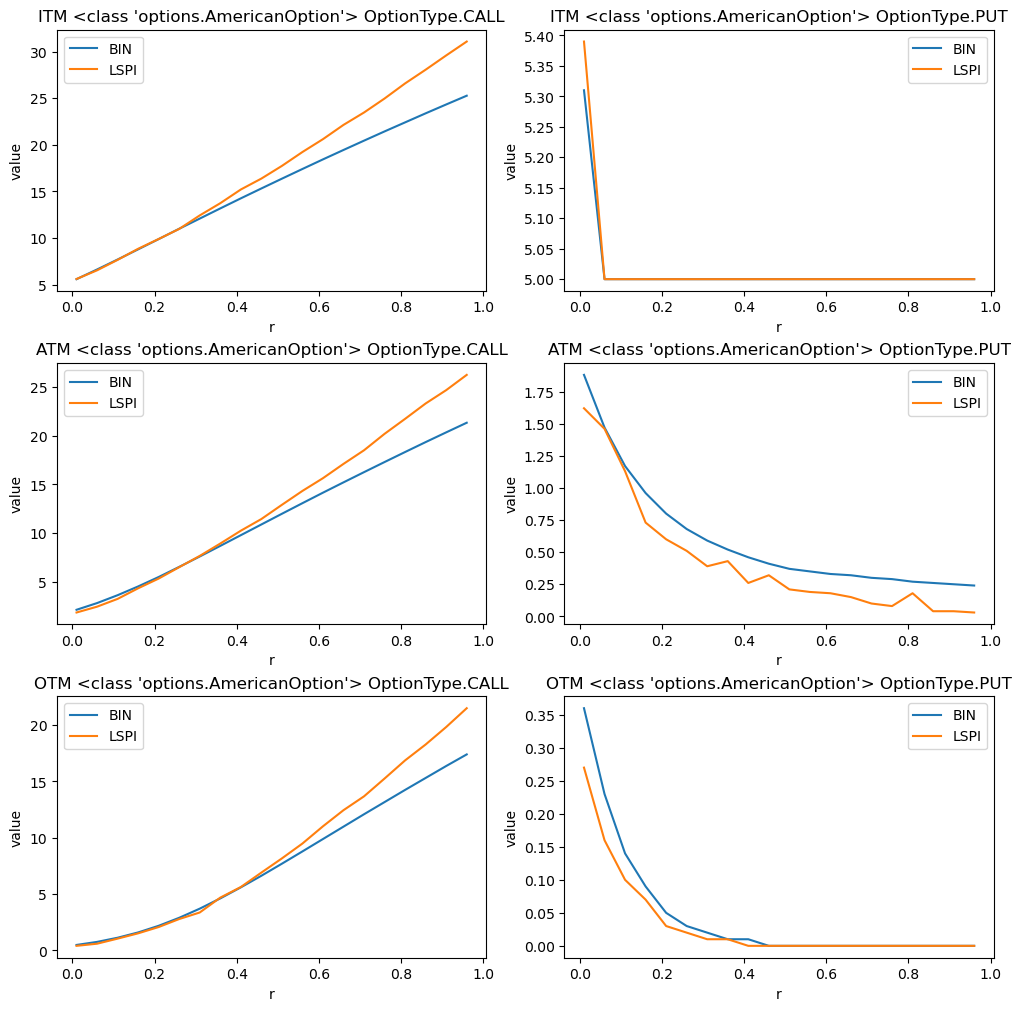

In [9]:
vary_r(call_options, put_options)

Yet again, LSPI values the call options higher than Binomial. As for put options, disregarding the spikes, except for the ATM, the values in other 2 cases seem to match. LSPI does not like ATM put as much as Binomial does.

#### Varying implied volatility

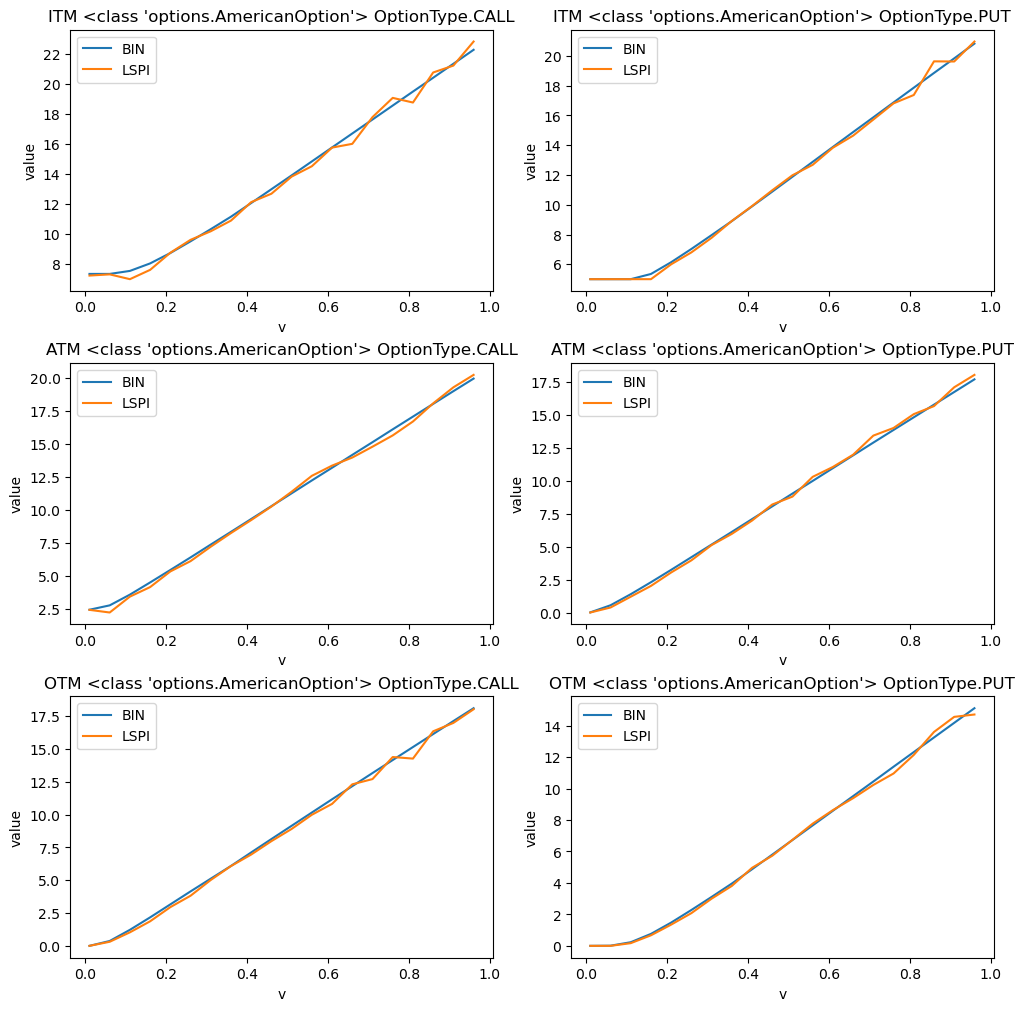

In [10]:
vary_v(call_options, put_options)

We see lot more spikes in LSPI valuations; this is expected as it's a simulation. LSPI more or less agrees with Binomial but there are occassional drops. Need to investigate further, but it might be that sometimes the policy does not converse and we hit maxiter.

#### Varying time to maturity

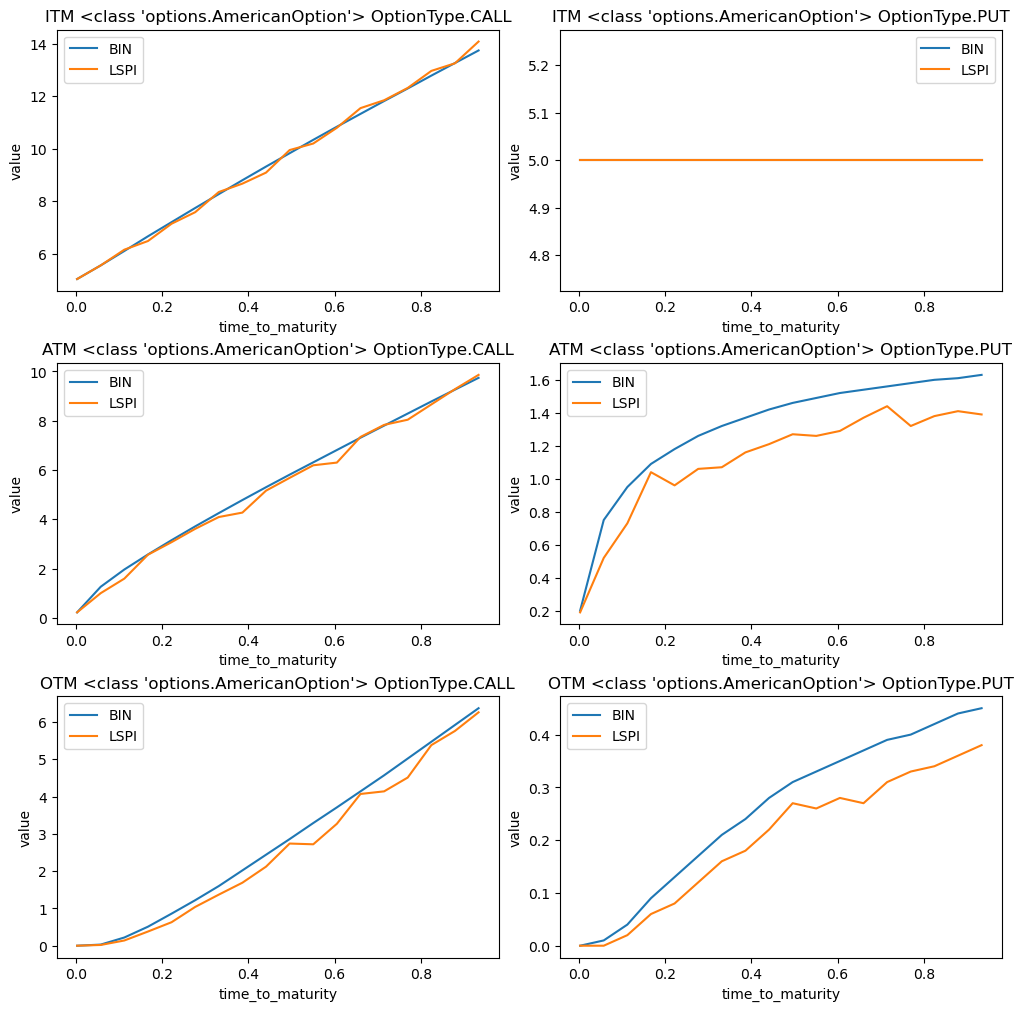

In [11]:
vary_t(call_options, put_options)

### LSPI and Binomial Model

#### Varying number of steps

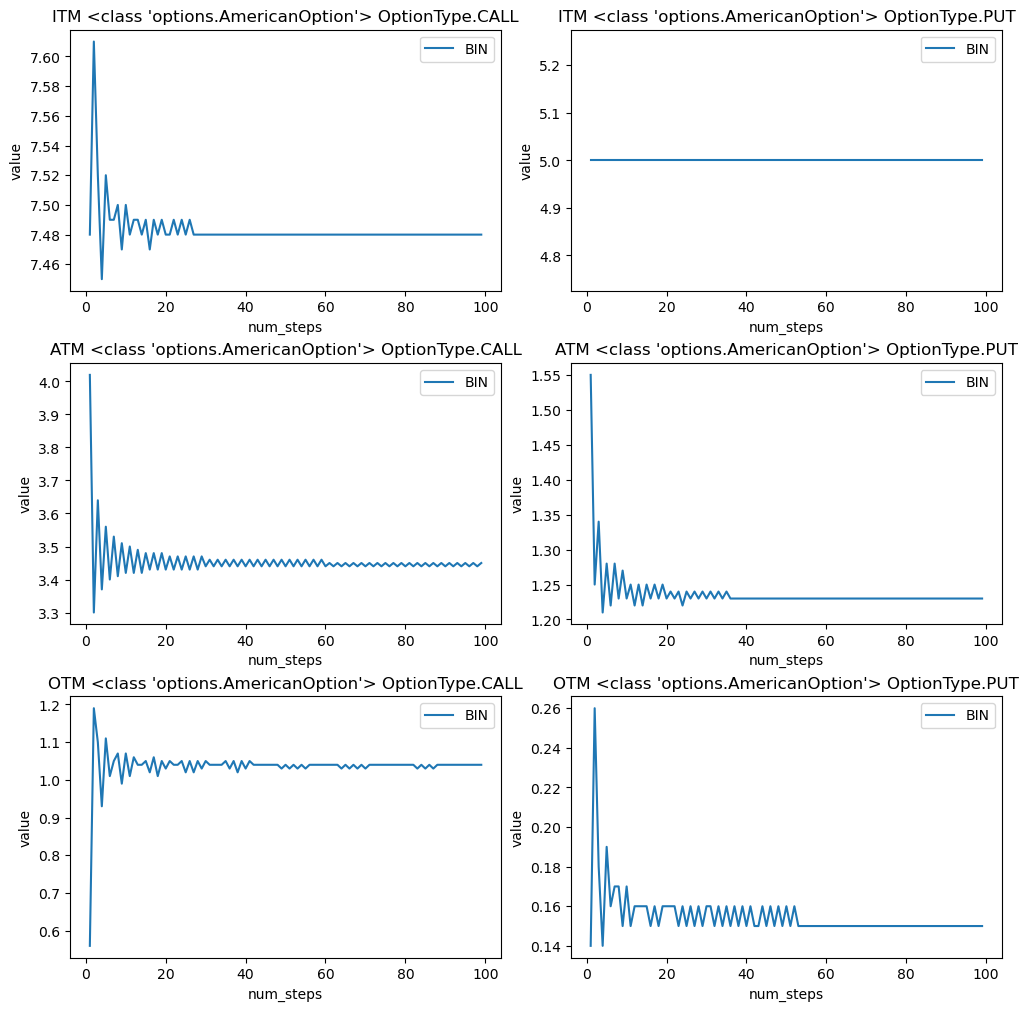

In [12]:
def vary_num_steps_bin(call_options, put_options, num_steps_range=range(1, 100)):
    fig, axes = plt.subplots(
        ncols=2,
        nrows=3,
        figsize=(10, 10),
        constrained_layout=True
    )

    for call_or_put_options in [call_options, put_options]:
        for i, (moneyness, option) in enumerate(call_or_put_options.items()):
            ax = axes[i, 0 if option.is_call() else 1]
            bin_prices = [binomial.price_option(option, risk_free_rate=0.1, volatility=0.1, time_to_maturity_in_years=3/12, num_steps=num_steps) for num_steps in num_steps_range]
            prices = [('BIN', bin_prices)]
            plot(ax, prices, num_steps_range, 'num_steps', 'value', f"{moneyness} {type(option)} {option.option_type}")

vary_num_steps_bin(call_options, put_options)

Binomial more or less settles on a value at 20-40 time steps.

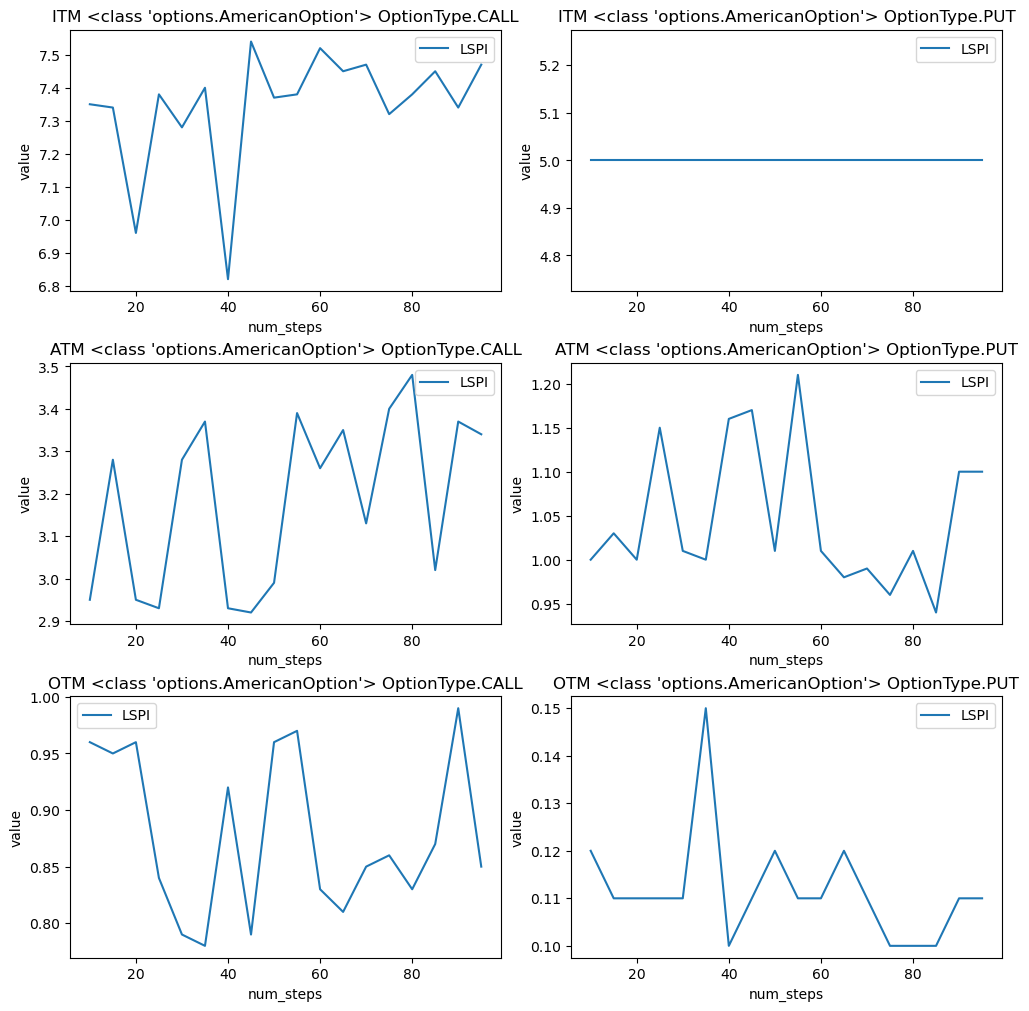

In [13]:
def vary_num_steps(call_options, put_options, num_steps_range=range(10, 100, 5)):
    fig, axes = plt.subplots(
        ncols=2,
        nrows=3,
        figsize=(10, 10),
        constrained_layout=True
    )

    for call_or_put_options in [call_options, put_options]:
        for i, (moneyness, option) in enumerate(call_or_put_options.items()):
            ax = axes[i, 0 if option.is_call() else 1]
            lspi_prices = [lspi.price_option(option, risk_free_rate=0.1, volatility=0.1, time_to_maturity_in_years=3/12, num_steps=num_steps) for num_steps in num_steps_range]
            prices = [('LSPI', lspi_prices)]
            plot(ax, prices, num_steps_range, 'num_steps', 'value', f"{moneyness} {type(option)} {option.option_type}")

vary_num_steps(call_options, put_options)

On the other hand, LSPI does not seem to settle on a particular value even when we increase the number of steps. 

#### Varying number of paths

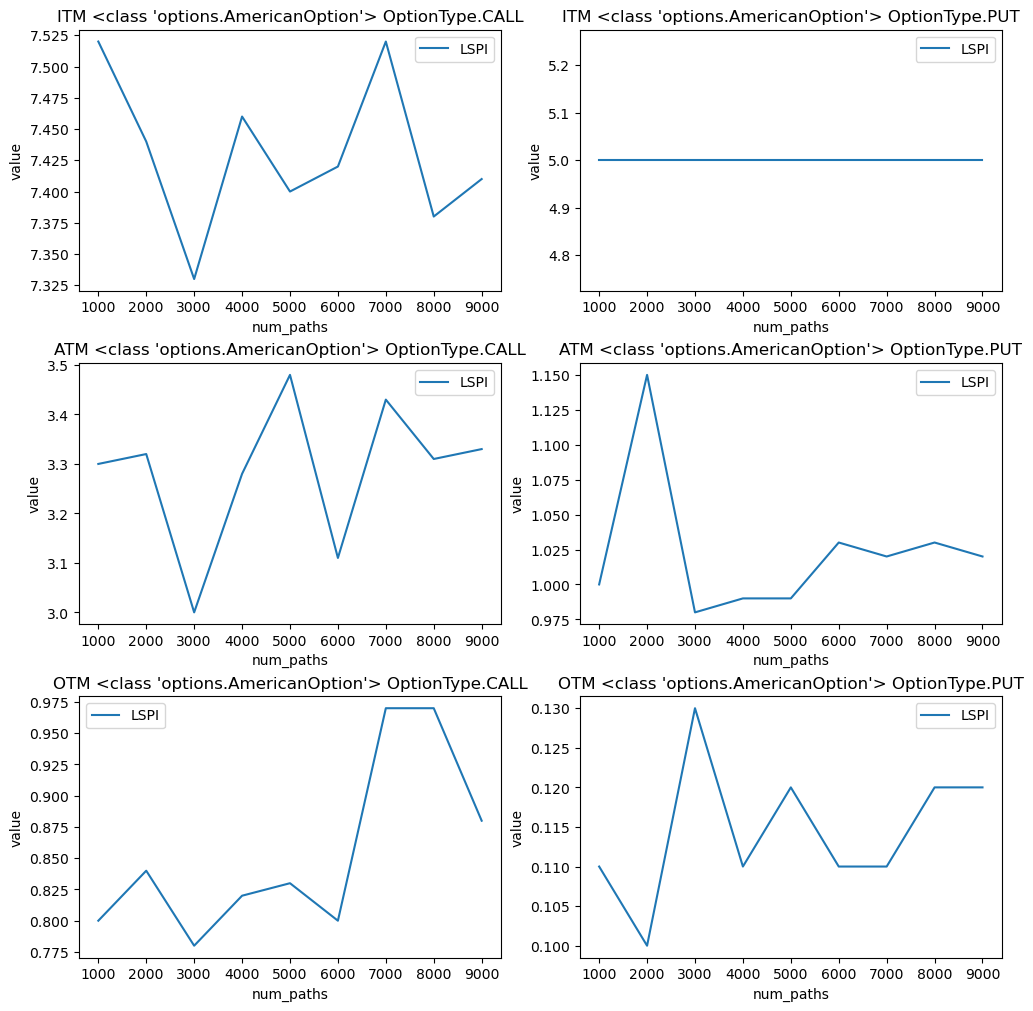

In [14]:
def vary_num_paths(call_options, put_options, num_paths_range=range(1000, 10000, 1000)):
    fig, axes = plt.subplots(
        ncols=2,
        nrows=3,
        figsize=(10, 10),
        constrained_layout=True
    )

    for call_or_put_options in [call_options, put_options]:
        for i, (moneyness, option) in enumerate(call_or_put_options.items()):
            ax = axes[i, 0 if option.is_call() else 1]
            lspi_prices = [lspi.price_option(option, risk_free_rate=0.1, volatility=0.1, time_to_maturity_in_years=3/12, num_paths=num_paths) for num_paths in num_paths_range]
            prices = [('LSPI', lspi_prices)]
            plot(ax, prices, num_paths_range, 'num_paths', 'value', f"{moneyness} {type(option)} {option.option_type}")

vary_num_paths(call_options, put_options)

I use the default is 5000 paths, 100 time steps for LSPI.

The paper this LSPI impl is based on uses num_steps 662-775 and num_paths 50000. And so it performs better than Longstaff-Schwartz least square method. I do not have such compute power. So we settle for this.

## $SPY option chains

Dataset: [Kaggle](https://www.kaggle.com/datasets/kylegraupe/spy-daily-eod-options-quotes-2020-2022)

In [36]:
import pandas as pd

df = pd.read_csv('spy_2020_2022.csv', parse_dates=True)
df.head()

/tmp/ipykernel_189966/537886797.py:3: DtypeWarning: Columns (8,9,10,11,12,13,15,17,18,20,21,23,24,25,26,27,28,29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('spy_2020_2022.csv', parse_dates=True)


,[QUOTE_UNIXTIME],[QUOTE_READTIME],[QUOTE_DATE],[QUOTE_TIME_HOURS],[UNDERLYING_LAST],[EXPIRE_DATE],[EXPIRE_UNIX],[DTE],[C_DELTA],[C_GAMMA],...,[P_LAST],[P_DELTA],[P_GAMMA],[P_VEGA],[P_THETA],[P_RHO],[P_IV],[P_VOLUME],[STRIKE_DISTANCE],[STRIKE_DISTANCE_PCT]
0,1630526400,2021-09-01 16:00,2021-09-01,16.0,451.85,2021-09-01,1630526400,0.0,1.000000,0.000000,...,0.010000,-0.000240,0.000000,0.000040,-0.005090,0.000000,3.412490,3.000000,181.9,0.402
1,1630526400,2021-09-01 16:00,2021-09-01,16.0,451.85,2021-09-01,1630526400,0.0,1.000000,0.000000,...,0.010000,-0.000630,0.000030,0.000190,-0.004800,0.000000,3.297370,0.000000,176.9,0.391
2,1630526400,2021-09-01 16:00,2021-09-01,16.0,451.85,2021-09-01,1630526400,0.0,1.000000,0.000000,...,0.010000,0.000000,0.000000,-0.000230,-0.005340,0.000000,3.183300,11.000000,171.9,0.380
3,1630526400,2021-09-01 16:00,2021-09-01,16.0,451.85,2021-09-01,1630526400,0.0,1.000000,0.000000,...,0.010000,-0.000160,0.000040,0.000380,-0.005320,0.000000,3.072170,50.000000,166.9,0.369
4,1630526400,2021-09-01 16:00,2021-09-01,16.0,451.85,2021-09-01,1630526400,0.0,1.000000,0.000000,...,0.010000,-0.000680,0.000000,0.000450,-0.005150,0.000000,2.962300,0.000000,161.9,0.358


In [37]:
columns = [col.lower().replace('[', '').replace(']', '').replace(' ' , '') for col in df.columns]
df.columns = columns

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3589079 entries, 0 to 3589078
Data columns (total 33 columns):
 #   Column               Dtype  
---  ------               -----  
 0   quote_unixtime       int64  
 1   quote_readtime       object 
 2   quote_date           object 
 3   quote_time_hours     float64
 4   underlying_last      float64
 5   expire_date          object 
 6   expire_unix          int64  
 7   dte                  float64
 8   c_delta              object 
 9   c_gamma              object 
 10  c_vega               object 
 11  c_theta              object 
 12  c_rho                object 
 13  c_iv                 object 
 14  c_volume             object 
 15  c_last               object 
 16  c_size               object 
 17  c_bid                object 
 18  c_ask                object 
 19  strike               float64
 20  p_bid                object 
 21  p_ask                object 
 22  p_size               object 
 23  p_last               object 
 24

In [39]:
df = df.sort_values(by="quote_date")

<Axes: >

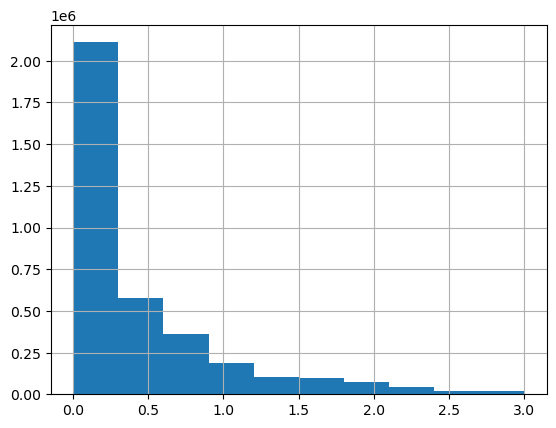

In [40]:
df["time_to_maturity"] = df.dte / 365

df.time_to_maturity.hist()

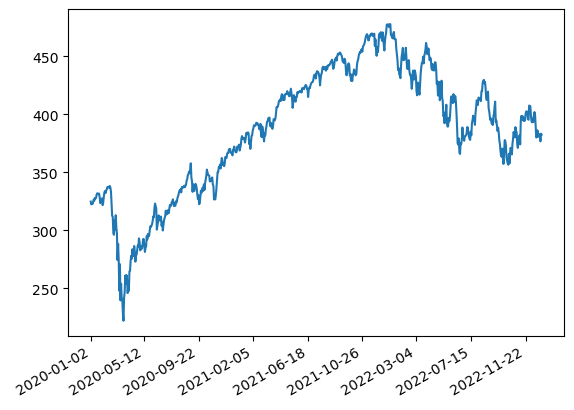

In [41]:
import matplotlib.dates as mdates


underlying_prices = df[["quote_date", "underlying_last"]].drop_duplicates()

fig, ax = plt.subplots()
ax.plot(underlying_prices.quote_date, underlying_prices.underlying_last)
fig.autofmt_xdate()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())

In [42]:
# Assume 3/12 expiry with 100 time steps
GeometricBrownianMotion.estimate_parameters(underlying_prices.underlying_last, dt=3/12/100)

(0.13696589282577737, 0.3186186769624654)

Bad idea because the time range is too large and volatility and drift are not necessarily constant.

In [43]:
df.isna().sum()

quote_unixtime         0
quote_readtime         0
quote_date             0
quote_time_hours       0
underlying_last        0
expire_date            0
expire_unix            0
dte                    0
c_delta                0
c_gamma                0
c_vega                 0
c_theta                0
c_rho                  0
c_iv                   0
c_volume               0
c_last                 0
c_size                 0
c_bid                  0
c_ask                  0
strike                 0
p_bid                  0
p_ask                  0
p_size                 0
p_last                 0
p_delta                0
p_gamma                0
p_vega                 0
p_theta                0
p_rho                  0
p_iv                   0
p_volume               0
strike_distance        0
strike_distance_pct    0
time_to_maturity       0
dtype: int64

Too few to care.

In [44]:
for column in ["underlying_last", "strike", "c_bid", "p_ask", "c_rho", "c_iv", "p_iv"]:
    df[column] = pd.to_numeric(df[column], errors='coerce')

In [45]:
df = df.dropna(axis=0)

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3201025 entries, 2457939 to 972357
Data columns (total 34 columns):
 #   Column               Dtype  
---  ------               -----  
 0   quote_unixtime       int64  
 1   quote_readtime       object 
 2   quote_date           object 
 3   quote_time_hours     float64
 4   underlying_last      float64
 5   expire_date          object 
 6   expire_unix          int64  
 7   dte                  float64
 8   c_delta              object 
 9   c_gamma              object 
 10  c_vega               object 
 11  c_theta              object 
 12  c_rho                float64
 13  c_iv                 float64
 14  c_volume             object 
 15  c_last               object 
 16  c_size               object 
 17  c_bid                float64
 18  c_ask                object 
 19  strike               float64
 20  p_bid                object 
 21  p_ask                float64
 22  p_size               object 
 23  p_last               object

<Axes: >

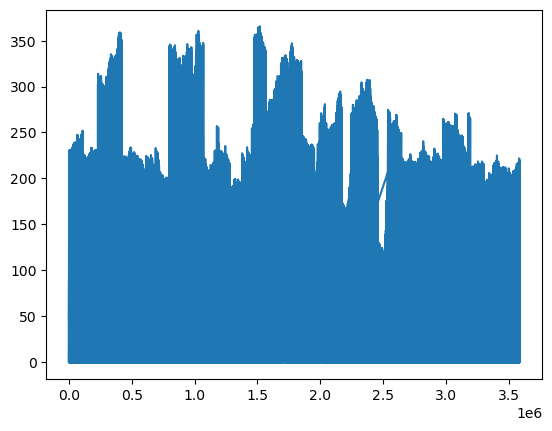

In [47]:
df.p_ask[df.p_ask < 1000].dropna().plot()

Apparently, one way to compute the risk-free rate is to do the following, according to [this one person](https://www.kaggle.com/code/khushipathak/heston-nn-amopt).

<Axes: >

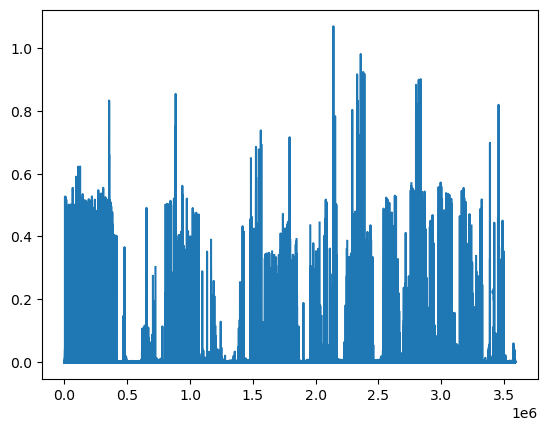

In [48]:
r = (df.c_rho / (df.c_bid * 100)).dropna()
r[r > 0].plot()

In [49]:
def create_option(option_style, option_type, S, K, qty, expire_date):
    return option_style(
        option_type=option_type,
        underlying=options.Stock("SPY", S),
        dividend_yield=None,
        qty=qty,
        strike_price=K,
        expiration_date=expire_date,
    )

But, we'll use the Put-Call parity, instead, to compute r.

In [50]:
import math


def compute_r(option_data):
    # Put Call Parity: P = C - SQ + KD
    C = option_data["c_bid"]
    P = option_data["p_ask"]
    S = option_data["underlying_last"]
    K = option_data["strike"]

    # Q = 1 (no dividends)
    D = (P - C + S)/K

    tau = option_data["time_to_maturity"]
    r = -(1/tau) * math.log(D)
    return r

In [51]:
from typing import Iterable
import implied_volatility


def price_options(pricer, options_df, is_call, compute_iv, **kwargs):
    prices = []
    for i, option_data in options_df.iterrows():
        option = create_option(
            options.AmericanOption,
            options.OptionType.CALL if is_call else options.OptionType.PUT,
            option_data["underlying_last"],
            option_data["strike"],
            option_data["c_volume" if is_call else "p_volume"],
            option_data["expire_date"],
        )
        value = option_data["c_bid" if is_call else "p_ask"]

        r = compute_r(option_data)
        tau = option_data["time_to_maturity"]

        iv = implied_volatility.compute_implied_volatility(
            option,
            value,
            black_scholes.price_option,
            risk_free_rate=r,
            time_to_maturity_in_years=tau,
        ) if compute_iv else float(option_data["c_iv" if is_call else "p_iv"])

        price = pricer(option,
                       risk_free_rate=r,
                       volatility=iv,
                       time_to_maturity_in_years=tau,
                       **kwargs)
        if isinstance(price, Iterable):
            price = price[0]

        prices.append(price)

    return prices

Text(0.5, 1.0, '$SPY Call options')

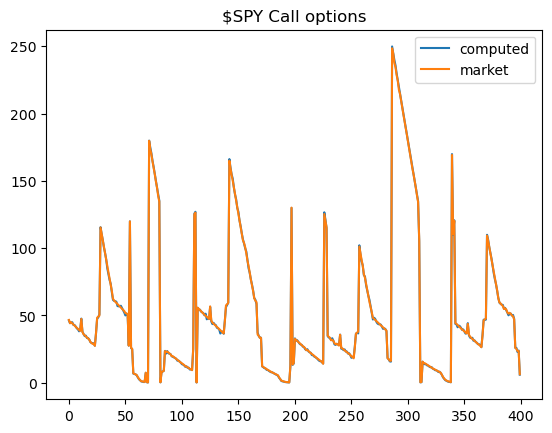

In [52]:
N = 400

computed_prices = price_options(lspi.price_option, df[:N], is_call=True, compute_iv=True)
plt.plot(range(N), computed_prices, label="computed")
plt.plot(range(N), df.c_bid[:N], label="market")
plt.legend()
plt.title("$SPY Call options")

Text(0.5, 1.0, '$SPY Put options')

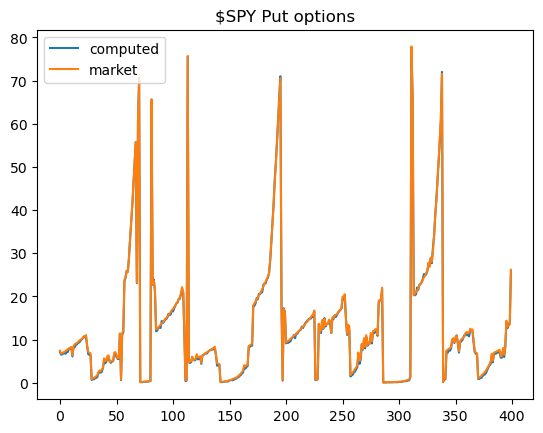

In [53]:
computed_prices = price_options(lspi.price_option, df[:N], is_call=False, compute_iv=True)
plt.plot(range(N), computed_prices, label="computed")
plt.plot(range(N), df.p_ask[:N], label="market")
plt.legend()
plt.title("$SPY Put options")

Text(0.5, 1.0, '$SPY Call options')

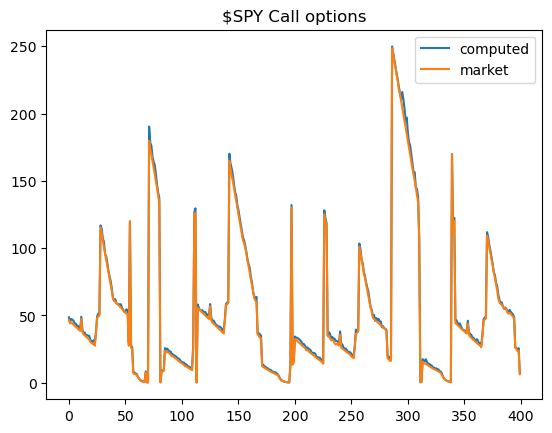

In [54]:
computed_prices = price_options(lspi.price_option, df[:N], is_call=True, compute_iv=False)
plt.plot(range(N), computed_prices, label="computed")
plt.plot(range(N), df.c_bid[:N], label="market")
plt.legend()
plt.title("$SPY Call options")

Text(0.5, 1.0, '$SPY Put options')

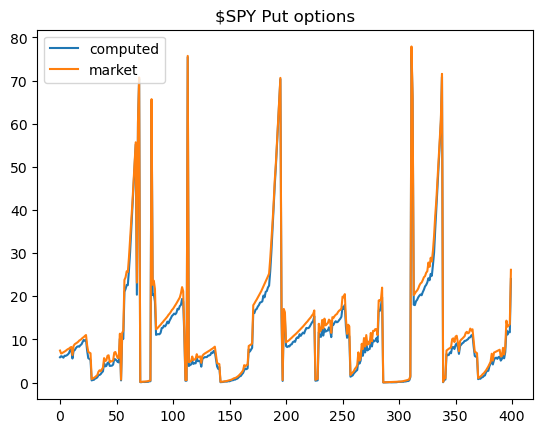

In [55]:
computed_prices = price_options(lspi.price_option, df[:N], is_call=False, compute_iv=False)
plt.plot(range(N), computed_prices, label="computed")
plt.plot(range(N), df.p_ask[:N], label="market")
plt.legend()
plt.title("$SPY Put options")

There are 3 mil options, I only price like 300 calls and 300 puts. Seems pretty good as long as we compute IV ourselves. Using provided IV causes some difference between computed and market price. Unfortunately, there isn't much variations in terms of moneyness and time of maturity to fully see how well our model perform. TODO: test different maturities and moneyness.

We compute r and v from the data, which includes the price of the option. This might seem like cheating, but apparently, it's common practice? But now we know our model works well (it's close to market value of the option). Also, the computed implied volatility can be used elsewhere if you wanted to too. Of course, implied volatility is based on market price, so it makes sense that we use the price to compute volalility. The price itself can be influenced by various other factors.